### Import libraries

In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

# Import R32, R125, IL info file
from HFCS_bmimSCN_PR import configuration

### Create model

In [2]:
# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Add properties parameter blocks to the flowsheet with specifications
m.fs.props = GenericParameterBlock(default=configuration)

2021-05-12 11:13:34 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.


In [3]:
m.fs.F101 = Flash(default={"property_package": m.fs.props,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 8


In [4]:
## Update conditions to reduce DOF

# Fix Heater H101 inlet conditions
m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "bmimSCN"].fix(0.001)

m.fs.F101.inlet.flow_mol[0].fix(1)
m.fs.F101.inlet.temperature.fix(300)
m.fs.F101.inlet.pressure.fix(200000)

# Fix F101 Flash outlet conditions
m.fs.F101.vap_outlet.temperature.fix(300)
m.fs.F101.deltaP.fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [5]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

### Get flash data

In [6]:
# Set pressures to loop over
P = [200000,400000,600000,800000,1000000,1200000,1400000,1600000]
# Set fraction of feed compositions of HFCs to loop over
HFC_feed_frac = [0.02,0.15,0.2,0.3,0.4,0.5,0.72,0.91,0.99]

# Make outlet arrays
IL_x = np.zeros((len(P),len(HFC_feed_frac)))
IL_y = np.zeros((len(P),len(HFC_feed_frac)))
R32_x = np.zeros((len(P),len(HFC_feed_frac)))
R32_y = np.zeros((len(P),len(HFC_feed_frac)))
R125_x = np.zeros((len(P),len(HFC_feed_frac)))
R125_y = np.zeros((len(P),len(HFC_feed_frac))) 

for i in range(len(P)):
    
    # Fix pressure
    m.fs.F101.inlet.pressure.fix(P[i])
    
    for j in range(len(HFC_feed_frac)):
        
        # Fix inlet mole fractions
        fract = 1 - HFC_feed_frac[j] 
        m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.2*HFC_feed_frac[j])
        m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.2*fract)
        m.fs.F101.inlet.mole_frac_comp[0, "bmimSCN"].fix(0.8) # increase inlet mol frac   
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        
        # solve the model
        status = solver.solve(m, tee = False)
        # model.display()
        
        # If solution is optimal store the concentration, and calculated temperatures in the created arrays
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            IL_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimSCN"])
            IL_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "bmimSCN"])
            R32_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
            R32_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
            R125_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
            R125_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])

            #Change this to feasible
            print("Running pressure:",P[i],"and HFC feed fraction",HFC_feed_frac[j])
#             print(value(m.fs.F101.liq_outlet.flow_mol[0]))
#             print(value(m.fs.F101.vap_outlet.flow_mol[0]))
        else:
            print('Infeasible.')

Running pressure: 200000 and HFC feed fraction 0.02
Running pressure: 200000 and HFC feed fraction 0.15
Running pressure: 200000 and HFC feed fraction 0.2
Running pressure: 200000 and HFC feed fraction 0.3
Running pressure: 200000 and HFC feed fraction 0.4
Running pressure: 200000 and HFC feed fraction 0.5
Running pressure: 200000 and HFC feed fraction 0.72
Running pressure: 200000 and HFC feed fraction 0.91
Running pressure: 200000 and HFC feed fraction 0.99
Running pressure: 400000 and HFC feed fraction 0.02
Running pressure: 400000 and HFC feed fraction 0.15
Running pressure: 400000 and HFC feed fraction 0.2
Running pressure: 400000 and HFC feed fraction 0.3
Running pressure: 400000 and HFC feed fraction 0.4
Running pressure: 400000 and HFC feed fraction 0.5
Running pressure: 400000 and HFC feed fraction 0.72
Running pressure: 400000 and HFC feed fraction 0.91
Running pressure: 400000 and HFC feed fraction 0.99
Running pressure: 600000 and HFC feed fraction 0.02
Running pressure: 60

In [7]:
IL_x = IL_x*100
IL_y = IL_y*100
R32_x = R32_x*100
R32_y = R32_y*100
R125_x = R125_x*100
R125_y = R125_y*100

print("IL_x =", IL_x)
print("IL_y =", IL_y)
print("R32_x =", R32_x)
print("R32_y =", R32_y)
print("R125_x =", R125_x)
print("R125_y =", R125_y)

IL_x = [[98.470128   97.91919575 97.70240411 97.25984926 96.80419295 96.33382947
  95.23693774 94.20113086 93.7327333 ]
 [96.79610517 95.83959296 95.45930855 94.67480088 93.85333297 92.98701039
  90.86052165 88.60366974 87.4183728 ]
 [94.8745862  93.62126568 93.12171994 92.08796725 90.99918419 89.84083696
  86.91737168 83.48126843 81.11424402]
 [92.47026319 91.01125703 90.43108094 89.23269202 87.97333917 86.63595423
  83.2621602  80.00000307 80.00000094]
 [80.0000011   0.         86.4690783   0.         83.96905726 82.61747672
  80.00000593 80.0000002  80.00000042]
 [79.99999927 80.00000757 79.99999582 80.00003964 80.00001903 80.00000221
  79.99999983 79.99999986 80.00000026]
 [79.99999945 80.00001036 79.99999674 80.00436609 79.99998718 79.99999754
  79.99999923 79.99999969 80.00000019]
 [79.99999921 79.99999836 79.99999513 80.00001769 80.00000031 79.99999543
  79.99999892 79.99999956 80.00000015]]
IL_y = [[1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06]
 [1.e-06 1.e-06

##### Store

In [31]:
points_x = []

for i in range(len(P)):
    for j in range(len(HFC_feed_frac)): #to shift how points are printed, shift the order
        points = (IL_x[i,j], R125_x[i,j], R32_x[i,j])
        points_x.append(points)

In [32]:
# points_y = []

# for i in range(len(P)):
#     for j in range(len(HFC_feed_frac)): #to shift how points are printed, shift the order
#         points = (IL_x[i,j], R125_x[i,j], R32_x[i,j])
#         points_x.append(points)

### Ternary Diagram

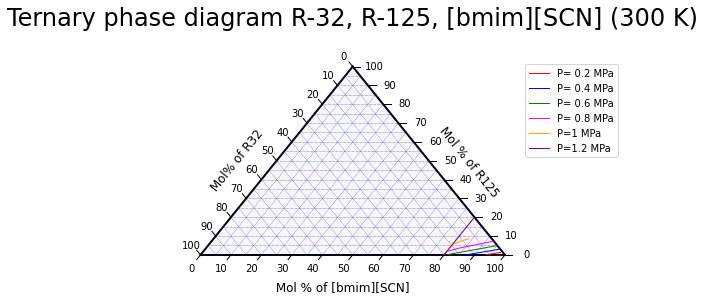

In [43]:
import ternary

scale = 100
figure, tax = ternary.figure(scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)

# Set Axis labels and Title
fontsize = 12
offset = 0.14
tax.set_title("Ternary phase diagram R-32, R-125, [bmim][SCN] (300 K)\n", fontsize=24)
tax.left_axis_label(" Mol% of R32", fontsize=fontsize, offset=offset)
tax.right_axis_label("Mol % of R125", fontsize=fontsize, offset=offset)
tax.bottom_axis_label(" Mol % of [bmim][SCN]", fontsize=fontsize, offset=offset)

# color_options = ['red','blue','green','black','orange','purple','teal','yellow','pink']

# for i in range(len(P)):
# #     color = color_options[i]
#     if P[i]<=1400000:
#         i = i + 1
#         print("points",i,"are:",points_x[9*i-9:9*i])
#         tax.plot(points_x[9*i-9:9*i], linewidth=1., color='red', linestyle="-")
#     elif P[i]==1500000:
#         i = i + 1
#         print("points",i,"are:",points_x[9*i-9:9*i])
#         tax.plot(points_x[9*i-8:9*i], linewidth=1., color='red', linestyle="-")
#     else:
#         i = i + 1
#         print("points",i,"are:",points_x[9*i-9:9*i])
#         tax.plot(points_x[9*i-6:9*i], linewidth=1., color='red', linestyle="-")

# tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
# tax.get_axes().axis('off')
# tax.clear_matplotlib_ticks()
# tax.show()
tax.plot(points_x[1:9], linewidth=1., color='red', linestyle="-", label='P= 0.2 MPa')
tax.plot(points_x[9:18], linewidth=1., color='blue', linestyle="-", label='P= 0.4 MPa')
tax.plot(points_x[18:27], linewidth=1., color='green', linestyle="-", label='P= 0.6 MPa')
tax.plot(points_x[27:36], linewidth=1., color='magenta', linestyle="-", label='P= 0.8 MPa')
tax.plot(points_x[40:45], linewidth=1., color='orange', linestyle="-", label='P=1 MPa')
tax.plot(points_x[45:54], linewidth=1., color='purple', linestyle="-", label='P=1.2 MPa')
# tax.plot(points_x[54:63], linewidth=1., color='black', linestyle="-", label='P=1.4 MPa')
# tax.plot(points_x[63:], linewidth=1., color='teal', linestyle="-", label='P=1.6 MPa')

tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
tax.legend(bbox_to_anchor=(1,1))
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()